In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

(examples:hrtem_quickstart)=
# HRTEM quickstart
This notebook demonstrates a basic HRTEM simulation of a double-walled carbon nanotube.

## Configuration

We start by (optionally) setting our configuration. See [documentation](reference:configuration) for details.

In [2]:
abtem.config.set({"device": "cpu", "fft": "fftw"})

## Atomic model

In this section we create the atomic model. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

We create two nanotubes with different radii using the [`nanotube`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.nanotube) function from ASE.

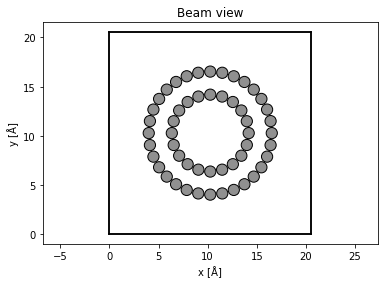

In [3]:
tube1 = ase.build.nanotube(10, 0, length=5)

tube2 = ase.build.nanotube(16, 0, length=5)

# combine the two nanotubes into a single structure
tubes = tube1 + tube2

# add vacuum in the x- and y-direction
tubes.center(vacuum=4.0, axis=(0, 1))

abtem.show_atoms(tubes, plane="xy", title="Beam view");

We rotate the nanotubes such the beam travels perpendicular to the length of the nanotubes.

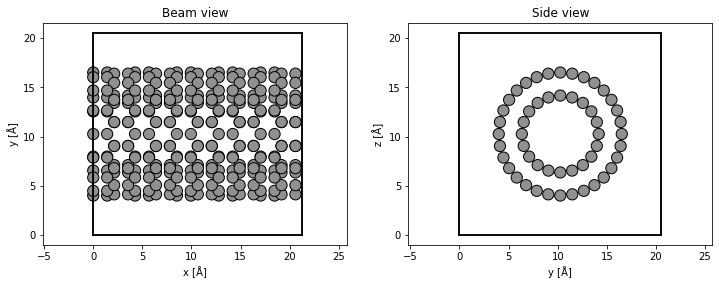

In [4]:
rotated_tubes = tubes.copy()

# rotate cell and atoms by 90 degrees around y
rotated_tubes.rotate("y", 90, rotate_cell=True)

# standardize unit cell (done automatically in an abTEM simulation)
rotated_tubes = abtem.standardize_cell(rotated_tubes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(rotated_tubes, plane="xy", ax=ax1, title="Beam view")
abtem.show_atoms(rotated_tubes, plane="yz", ax=ax2, title="Side view");

## Potential

We create an ensemble of potentials using the frozen phonon model. See our [walkthrough on frozen phonons](walkthrough:frozen_phonons). 

In [18]:
frozen_phonons = abtem.FrozenPhonons(rotated_tubes, 16, sigmas=0.1)

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [6]:
potential = abtem.Potential(
    frozen_phonons,
    sampling=0.05,
    projection="infinite",
    slice_thickness=1,
)

## Wave function

We create a plane wave function at an energy of 100 keV. See our [walkthrough on wave functions](walkthrough:wave_functions). 

In [7]:
wave = abtem.PlaneWave(energy=100e3)

## Multislice

We run the multislice algorithm to calculate the exit waves, see our [walkthrough on multislice](walkthrough:multislice).

In [8]:
exit_wave = wave.multislice(potential)

In [9]:
exit_wave.compute()

[########################################] | 100% Completed | 3.52 ss


## Contrast transfer function

We create a contrast transfer function of the objective lens, see our [walkthrough on the contrast transfer function](walkthrough:contrast_transfer_function)

In [10]:
Cs = -8e-6 * 1e10  # spherical aberration (-8 um)

ctf = abtem.CTF(Cs=Cs, energy=wave.energy, defocus="scherzer", semiangle_cutoff=45)

print(f"defocus = {ctf.defocus:.2f} Å")

defocus = -66.65 Å


We include partial coherence in the quasi-coherent approximation. For more accurate descriptions of partial coherence, see our [tutorial on partial coherence](tutorials:partial_coherence).

In [11]:
Cc = 1.0e-3 * 1e10  # chromatic aberration (1.2 mm)
energy_spread = 0.35  # standard deviation energy spread (0.35 eV)

focal_spread = Cc * energy_spread / exit_wave.energy

incoherent_ctf = ctf.copy()
incoherent_ctf.focal_spread = focal_spread

We show a profiles of the contrast transfer functions.

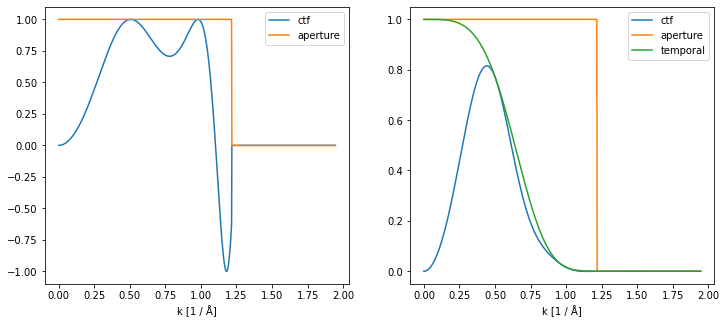

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ctf.profiles().show(ax=ax1)
incoherent_ctf.profiles().show(ax=ax2);

We apply the contrast transfer function, then calculate the intensities of the wave functions.

In [13]:
measurement_ensemble = exit_wave.apply_ctf(incoherent_ctf).intensity()

measurement_ensemble.shape

(16, 426, 411)

The result is an ensemble of images, one for each frozen phonon, we average the ensemble to obtain the final image. 

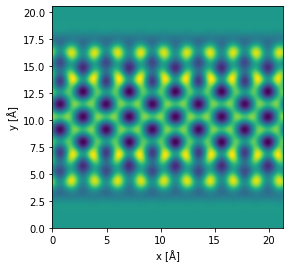

In [14]:
measurement = measurement_ensemble.mean(0)

measurement.show();

## Postprocessing

Many tasks requires additional post-processing steps. Below we apply Poisson noise to simulate the shot noise of a given finite electron dose.

(<Figure size 432x288 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

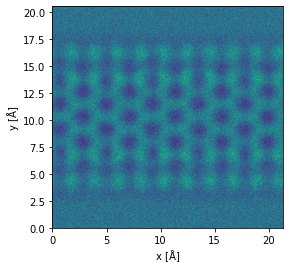

In [15]:
noisy_measurement = measurement.poisson_noise(dose_per_area=1e4)

noisy_measurement.show()

Showing the results as a line profile often provides a better sense of relative intensities. 

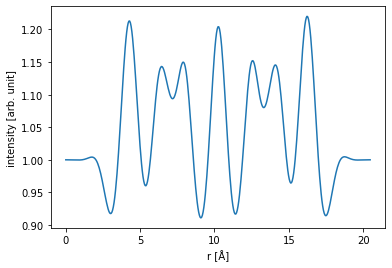

In [16]:
start = (0, 0)
end = (0, potential.extent[1])

measurement.interpolate_line(start, end).show();

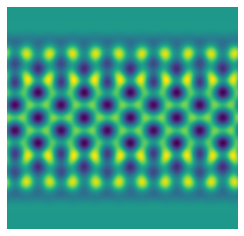

In [17]:
# this cell produces a thumbnail for the online documentation

fig, ax = measurement.show()
ax.axis("off")
plt.savefig("../thumbnails/hrtem_quickstart.png", bbox_inches="tight", pad_inches=0)